In [1]:
from torch.utils.data import Dataset
import os
import tifffile as tiff
import numpy as np
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter

from scipy.stats import mode



In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = []
        self.labels = []
        self.class_names = []  # To store class (folder) names
        self.class_to_idx = {}  # To map class names to indices
        self.class_counts = {}  # To store count of images per class

        # Define a transformation to resize the images
        self.transform = transforms.Compose([transforms.Resize((96, 96))])

        # Get all subdirectories (classes)
        self.class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        self.class_names.sort()  # Ensure consistent ordering
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Load images and assign labels based on folder name
        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            class_images = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
            self.image_files.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))  # Assign class index as label
            
            # Store the count of images per class
            self.class_counts[class_name] = len(class_images)

        # Print labels and counts
        self.print_labels_and_counts()
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)
        #print(image.shape)
        # Apply the resizing transform (resize)
        image = self.transform(image)

        flattened_image = image.view(-1).numpy()  # Reshape to (96*96*3, )
        
        return flattened_image, label

    def print_labels_and_counts(self):
        print("Class Labels and Counts:")
        for class_name, class_index in self.class_to_idx.items():
            print(f"Class '{class_name}' (Index {class_index}): {self.class_counts[class_name]} images")




image_dir = r"G:\classification\cond_all"


dataset = ImageDataset(image_dir)  # Initialize dataset, it will automatically print labels and counts


Class Labels and Counts:
Class 'cond7_all' (Index 0): 472 images
Class 'ex' (Index 1): 40 images
Class 'sd' (Index 2): 103 images


In [3]:
for i in range(len(dataset)):
    falttened_image,l = dataset[i]
    print(falttened_image.shape)
    print(l)  
    break

(27648,)
0


In [4]:
type(falttened_image)

numpy.ndarray

In [5]:
falttened_image.shape

(27648,)

In [6]:
# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []
    
    for i in range(len(dataset)):
        flattened_image, label = dataset[i]  # Unpack the image and label
        all_images.append(flattened_image)
        all_labels.append(label)
    
    # Stack all the flattened images to create a large dataset
    # Convert to numpy arrays for K-Means input
    return np.vstack(all_images), np.array(all_labels)

In [7]:
X, labels = load_image_data(dataset) 

In [8]:
X.shape

(615, 27648)

In [9]:
print(type(labels))

labels.shape

<class 'numpy.ndarray'>


(615,)

c:\Users\k54739\.conda\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


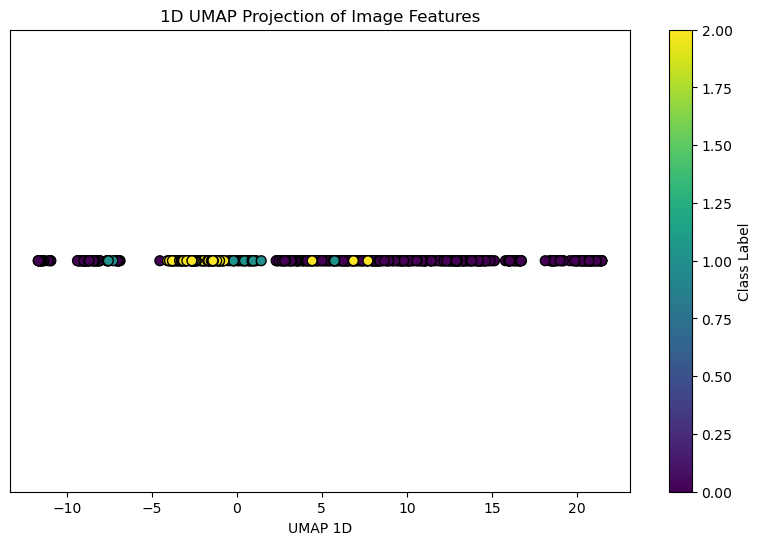

In [15]:
import umap
import matplotlib.pyplot as plt

# Assuming X and labels have been created from your dataset
# X, labels = load_image_data(dataset)

# Apply 1D UMAP projection
umap_1d = umap.UMAP(n_components=1, random_state=42)
umap_result = umap_1d.fit_transform(X)  # umap_result shape: (N, 1)

# Plot 1D UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], 
            np.zeros_like(umap_result[:, 0]), 
            c=labels, 
            cmap='viridis', 
            edgecolors='k', 
            s=50)
plt.colorbar(label='Class Label')
plt.title('1D UMAP Projection of Image Features')
plt.xlabel('UMAP 1D')
plt.yticks([])  # Hide y-axis ticks since they're all zeros
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


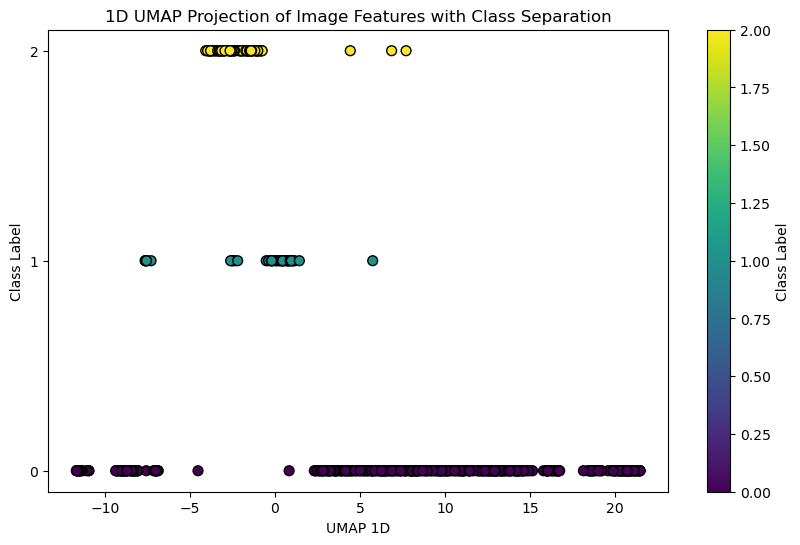

In [16]:
import umap
import matplotlib.pyplot as plt

# Assuming X and labels have been created from your dataset
# X, labels = load_image_data(dataset)

# Apply 1D UMAP projection
umap_1d = umap.UMAP(n_components=1, random_state=42)
umap_result = umap_1d.fit_transform(X)  # umap_result shape: (N, 1)

# Plot 1D UMAP results with y-axis as the class labels
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], labels, c=labels, cmap='viridis', edgecolors='k', s=50)
plt.colorbar(label='Class Label')
plt.title('1D UMAP Projection of Image Features with Class Separation')
plt.xlabel('UMAP 1D')
plt.ylabel('Class Label')
plt.yticks(sorted(set(labels)))  # Ensure y-axis ticks match the unique class labels (e.g., 0, 1, 2)
plt.show()


In [17]:
import numpy as np

# Step 1: Calculate the mean value of UMAP 1D for each class
unique_classes = np.unique(labels)
class_means = {}

for cls in unique_classes:
    class_umap_values = umap_result[labels == cls]
    class_mean = np.mean(class_umap_values)
    class_means[cls] = class_mean

print("Mean UMAP 1D Value for Each Class:")
for cls, mean_val in class_means.items():
    print(f"Class {cls}: {mean_val:.4f}")

# Step 2: Find the middle class based on the mean value (median)
sorted_classes = sorted(class_means.items(), key=lambda x: x[1])
middle_class = sorted_classes[len(sorted_classes) // 2][0]
print(f"\nMiddle Class (based on median mean value): Class {middle_class}")

# Step 3: Find the min and max value of UMAP 1D for each class
class_min_max = {}

for cls in unique_classes:
    class_umap_values = umap_result[labels == cls]
    class_min = np.min(class_umap_values)
    class_max = np.max(class_umap_values)
    class_min_max[cls] = (class_min, class_max)

print("\nMin and Max UMAP 1D Values for Each Class:")
for cls, (min_val, max_val) in class_min_max.items():
    print(f"Class {cls}: Min = {min_val:.4f}, Max = {max_val:.4f}")

# Step 4: Number of data points from first class that passed the minimum value of the middle class
middle_class_min = class_min_max[middle_class][0]
class_0_values = umap_result[labels == 0]
class_0_pass_count = np.sum(class_0_values > middle_class_min)
print(f"\nNumber of data points from Class 0 that passed the minimum value of Middle Class: {class_0_pass_count}")

# Step 5: Number of data points from third class that lies before the maximum value of the middle class
middle_class_max = class_min_max[middle_class][1]
class_2_values = umap_result[labels == 2]
class_2_before_count = np.sum(class_2_values < middle_class_max)
print(f"Number of data points from Class 2 that lies before the maximum value of Middle Class: {class_2_before_count}")

# Step 6: Calculate accuracy
total_other_class_points_in_middle_range = class_0_pass_count + class_2_before_count
total_datapoints = len(umap_result)
accuracy = (total_datapoints - total_other_class_points_in_middle_range) / total_datapoints
print(f"\nAccuracy: {accuracy:.4f}")


Mean UMAP 1D Value for Each Class:
Class 0: 8.1130
Class 1: -0.9631
Class 2: -2.1188

Middle Class (based on median mean value): Class 1

Min and Max UMAP 1D Values for Each Class:
Class 0: Min = -11.6780, Max = 21.4621
Class 1: Min = -7.6303, Max = 5.7477
Class 2: Min = -4.0681, Max = 7.7094

Number of data points from Class 0 that passed the minimum value of Middle Class: 406
Number of data points from Class 2 that lies before the maximum value of Middle Class: 101

Accuracy: 0.1756


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE to reduce the data to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)  # X is your image dataset in flattened form

# Define colors for the different classes
num_classes = len(np.unique(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(labels)):
    plt.scatter(
        X_tsne[labels == class_label, 0], 
        X_tsne[labels == class_label, 1], 
        label=f'Class {class_label}',
        color=colors[i],
        alpha=0.7
    )

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Image Data")
plt.legend()
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE to reduce the data to 1D
tsne = TSNE(n_components=1, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X).flatten()  # X is your dataset in flattened form

# Define colors for the different classes
num_classes = len(np.unique(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Plot the t-SNE results in 1D
plt.figure(figsize=(12, 2))
for i, class_label in enumerate(np.unique(labels)):
    plt.scatter(
        X_tsne[labels == class_label], 
        [i] * sum(labels == class_label),  # Slight jitter for better visibility
        label=f'Class {class_label}',
        color=colors[i],
        alpha=0.7
    )

plt.xlabel("t-SNE 1D Component")
plt.yticks([])  # Remove y-axis labels
plt.title("1D t-SNE Visualization of Image Data")
plt.legend()
plt.show()


import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the image data
X, y = load_image_data(dataset)

# Create and fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab20', alpha=0.6)

# Add labels and title
plt.xlabel(f'First Principal Component\nExplained variance ratio: {pca.explained_variance_ratio_[0]:.3f}')
plt.ylabel(f'Second Principal Component\nExplained variance ratio: {pca.explained_variance_ratio_[1]:.3f}')
plt.title('PCA of Image Dataset')

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=scatter.cmap(scatter.norm(class_idx)), 
                            label=class_name, markersize=10)
                  for class_name, class_idx in dataset.class_to_idx.items()]
plt.legend(handles=legend_elements, title='Classes', 
          bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print the total explained variance ratio
total_var = pca.explained_variance_ratio_.sum()
print(f"\nTotal explained variance ratio: {total_var:.3f}")

# Print component information
print("\nPCA Components shape:", pca.components_.shape)
print("Number of components:", pca.n_components_)

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the image data
X, y = load_image_data(dataset)

# Define dark colors for each class
dark_colors = ['darkred', 'darkblue', 'darkgreen', 'purple', 'navy', 
               'darkmagenta', 'darkorange', 'crimson', 'darkslategray', 'indigo']

# Create a color map dictionary
color_map = {idx: color for idx, color in enumerate(dark_colors[:len(dataset.class_names)])}

# Create and fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Plot each class separately to ensure proper legend
for class_idx in dataset.class_to_idx.values():
    mask = y == class_idx
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=color_map[class_idx],
               label=list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(class_idx)],
               alpha=0.6)

# Add labels and title
plt.xlabel(f'First Principal Component\nExplained variance ratio: {pca.explained_variance_ratio_[0]:.3f}')
plt.ylabel(f'Second Principal Component\nExplained variance ratio: {pca.explained_variance_ratio_[1]:.3f}')
plt.title('PCA of Image Dataset')

# Add legend
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print the total explained variance ratio
total_var = pca.explained_variance_ratio_.sum()
print(f"\nTotal explained variance ratio: {total_var:.3f}")

# Print component information
print("\nPCA Components shape:", pca.components_.shape)
print("Number of components:", pca.n_components_)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load image data
image_data, labels = load_image_data(dataset)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_data)

# Scatter plot of PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Image Dataset')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load image data
image_data, labels = load_image_data(dataset)

# Apply PCA to reduce dimensions to 1
pca = PCA(n_components=1)
pca_result = pca.fit_transform(image_data)

# Scatter plot of 1D PCA results (using an artificial y-axis)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], np.zeros_like(pca_result[:, 0]), c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.xlabel('PCA Component 1')
plt.title('1D PCA Visualization of Image Dataset')
plt.yticks([])  # Hide y-axis ticks as they are not meaningful
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load image data
image_data, labels = load_image_data(dataset)

# Apply PCA to reduce dimensions to 1
pca = PCA(n_components=1)
pca_result = pca.fit_transform(image_data)

# Convert labels to a NumPy array (if they aren't already)
labels = np.array(labels)

# Create a scatter plot where y-values correspond to the class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], labels, c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.xlabel('PCA Component 1')
plt.ylabel('Class Label')
plt.title('1D PCA Visualization of Image Dataset with Class Separation')
plt.yticks(np.unique(labels))  # Ensure y-axis ticks match the unique class labels
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example: Load image data (assumes load_image_data returns image_data and labels)
image_data, labels = load_image_data(dataset)

# Apply PCA to reduce dimensions to 1
pca = PCA(n_components=1)
pca_result = pca.fit_transform(image_data)  # pca_result shape: (N, 1)

# Convert labels to a NumPy array (if not already)
labels = np.array(labels)

# -----------------------------
# Step 1: Compute mean, min, and max PCA=1 values for each class
# -----------------------------
unique_classes = np.unique(labels)
class_means = {}
class_min_max = {}

for cls in unique_classes:
    # Get indices for the current class
    cls_indices = np.where(labels == cls)[0]
    # Extract the PCA=1 values for the current class
    cls_pca_values = pca_result[cls_indices, 0]
    # Compute mean, min, and max for the class
    class_means[cls] = np.mean(cls_pca_values)
    class_min_max[cls] = {
        'min': np.min(cls_pca_values),
        'max': np.max(cls_pca_values)
    }

# Print the mean PCA value for each class
print("Mean PCA value for each class:")
for cls in unique_classes:
    print(f"Class {cls}: {class_means[cls]:.4f}")

# -----------------------------
# Step 2: Determine the middle class based on the median of the mean PCA values
# -----------------------------
# Sort classes by their mean PCA values
sorted_classes = sorted(class_means.keys(), key=lambda x: class_means[x])
# The middle class is the one at the median index
middle_class = sorted_classes[len(sorted_classes) // 2]

print(f"\nMiddle Class (by mean PCA value): {middle_class}")
middle_class_range_min = class_min_max[middle_class]['min']
middle_class_range_max = class_min_max[middle_class]['max']
print(f"Middle Class PCA value range: {middle_class_range_min:.4f} to {middle_class_range_max:.4f}")

# -----------------------------
# Step 3: Count data points from other classes that lie within the middle class range
# -----------------------------
points_in_range = {}
total_points_in_range = 0

for cls in unique_classes:
    if cls != middle_class:
        cls_indices = np.where(labels == cls)[0]
        cls_pca_values = pca_result[cls_indices, 0]
        # Count data points whose PCA value lies between the min and max of the middle class
        count = np.sum((cls_pca_values >= middle_class_range_min) & (cls_pca_values <= middle_class_range_max))
        points_in_range[cls] = count
        total_points_in_range += count

print("\nNumber of data points from other classes that lie in the range of the middle class:")
for cls in points_in_range:
    print(f"Class {cls}: {points_in_range[cls]} data points")

# -----------------------------
# Step 4: Compute Accuracy
# -----------------------------
# Accuracy = (total datapoints - total data points from other classes in the middle class range) / total datapoints
total_datapoints = len(pca_result)
accuracy = (total_datapoints - total_points_in_range) / total_datapoints

print(f"\nAccuracy: {accuracy:.4f}")
